# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [78]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from sklearn import metrics
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from collections import OrderedDict

from sklearn import metrics


%matplotlib inline

Прочитаем исходные данные:

In [79]:
data = pd.read_csv('data/_unconv.zip')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [81]:
# числовые признаки
types = data.dtypes
num_features = list(types.index)
num_features

['Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']

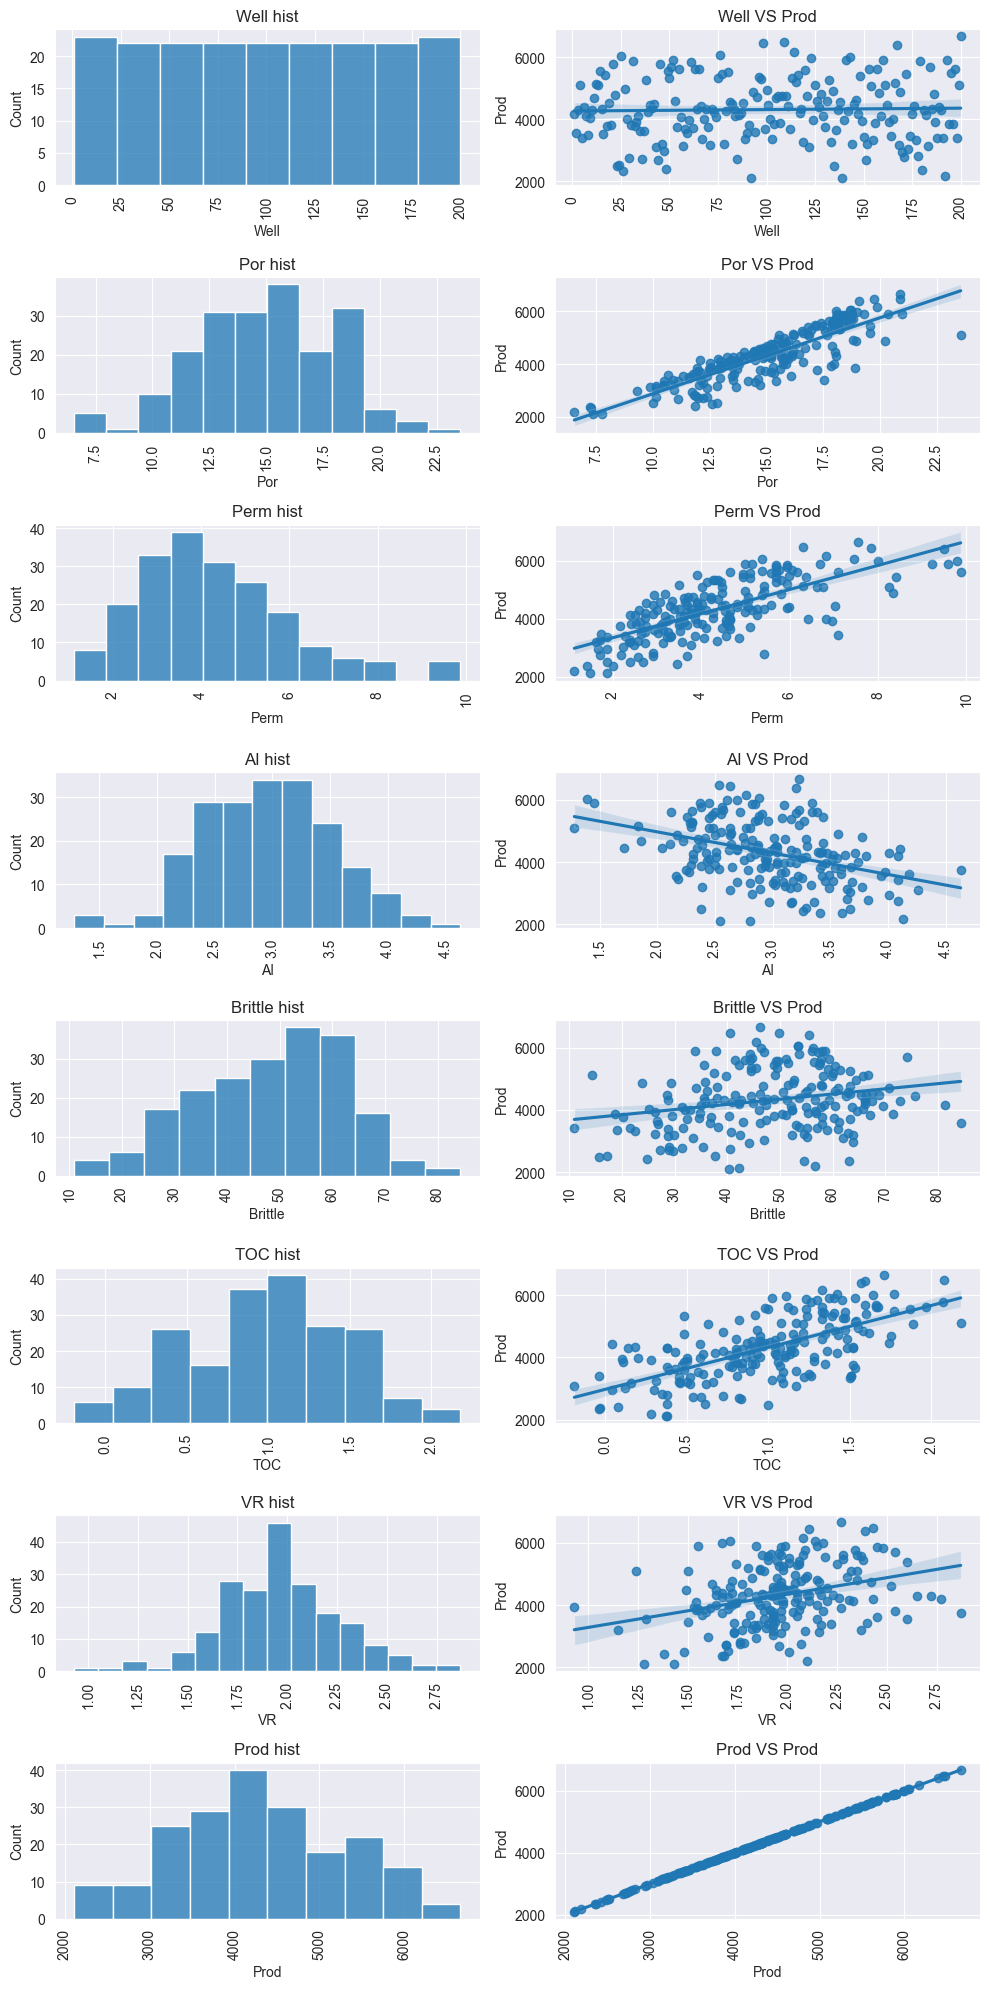

In [85]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(10, 20))

#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features):
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    histplot.set_title('{} hist'.format(feature))
    histplot.xaxis.set_tick_params(rotation=90)

    regplot = sns.regplot(data=data, x=feature, y='Prod', ax=axes[i][1])
    regplot.set_title('{} VS Prod'.format(feature))
    regplot.xaxis.set_tick_params(rotation=90)

plt.tight_layout()

Распределение данных близко к нормальному. Исключение - равномерное для Well.

Целевая переменная Prod имеет обратную зависимость от признака AI, в остальных случаях - прямая зависимость.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [86]:
# матрица корреляций
data.corr()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


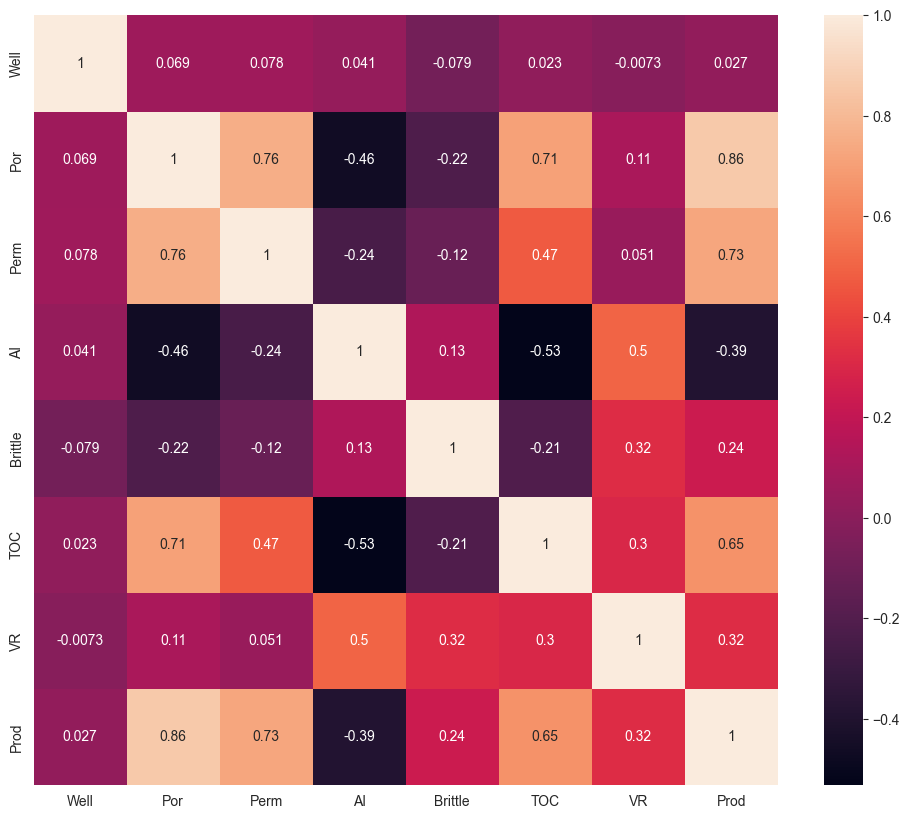

In [87]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True);

In [88]:
print('Rank:', np.linalg.matrix_rank(data.corr()))

Rank: 8


In [90]:
print('Determinant:', round(np.linalg.det(data.corr()), 5))

Determinant: 0.00073


In [92]:
#MHK
y = data[['Prod']]
A = np.column_stack((np.ones(200), data[['Well', 'Por', 'Perm','AI', 'Brittle', 'TOC', 'VR']]))
w_hat=np.linalg.inv(A.T@A)@A.T@y
print(np.round(w_hat.values, 0))

[[-1232.]
 [    0.]
 [  230.]
 [  116.]
 [ -365.]
 [   25.]
 [  -78.]
 [  785.]]


In [93]:
w_hat1=np.linalg.lstsq(A, y, rcond=None)
print(w_hat1)

(array([[-1.23230803e+03],
       [ 5.07003631e-02],
       [ 2.30179140e+02],
       [ 1.16239006e+02],
       [-3.65202301e+02],
       [ 2.49943700e+01],
       [-7.84009294e+01],
       [ 7.85259815e+02]]), array([7863008.02805328]), 8, array([1.75726792e+03, 3.87998844e+02, 7.41712919e+01, 1.61441542e+01,
       1.13261139e+01, 5.07204769e+00, 1.60361699e+00, 9.73609868e-01]))


Сильнее всего с целевой переменной связаны факторы:

Por — пористость скважины (%) - 0.86

Perm — проницаемость скважины - 0.73

TOC — общий органический углерод (%) - 0.65

Корреляционная матрица является плохо обусловленной ее определитель - 0.0007 близок к нулю.

Матрица корреляции имеет максимальный ранг, прямой линейной взаимосвязи между факторами не наблюдается, однако ее определитель стремится к нулю.

Получение коэффициентов линейной регрессии по методу OLS в данном случае возможно, то есть ошибку вырожденности матрицы не выдает, однако коэффициенты получаются очень большие.


### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [94]:
X = data.drop(['Prod'], axis=1)
y = data[['Prod']]
A = np.column_stack((np.ones(200), X))
w_hat=np.linalg.inv(A.T@A)@A.T@y
print('w_0: {}'.format(np.round(w_hat.iloc[0], 0)))
print('w_wel: {}'.format(np.round(w_hat.iloc[1], 0)))
print('w_por: {}'.format(np.round(w_hat.iloc[2], 0)))
print('w_perm: {}'.format(np.round(w_hat.iloc[3], 0)))
print('w_hat: {}'.format(np.round(w_hat.values, 0)))

w_0: Prod   -1232.0
Name: 0, dtype: float64
w_wel: Prod    0.0
Name: 1, dtype: float64
w_por: Prod    230.0
Name: 2, dtype: float64
w_perm: Prod    116.0
Name: 3, dtype: float64
w_hat: [[-1232.]
 [    0.]
 [  230.]
 [  116.]
 [ -365.]
 [   25.]
 [  -78.]
 [  785.]]


На целевую переменную не оказывает влияния Well — идентификатор скважины - соответствующий коэффициент 0

TOC — общий органический углерод (%) и AI — акустический импеданс имеют обратную взаимосвязь с целевым признаком, коэффициенты отрицательные.

Остальные факторы имеют прямую взаимосвязь с целевым признаком


### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [96]:
new_dict = {
    '1':[1],
    'Well': [106.0],
    'Por': [15.32],
    'Perm': [3.71],
    'AI': [3.29],
    'Brittle': [55.99],
    'TOC': [1.35],
    'VR': [2.42]
 }
new_y = 4748.315024
new_df = pd.DataFrame(new_dict)
new_X = np.array(new_df.values)
y_pred = (new_X@w_hat).values

mae = np.round((new_y- y_pred), 0)

print('prediction:', y_pred)
print('MAE:', mae)

mape_new = np.round((abs(new_y- y_pred))/new_y*100, 1)
print('MAPE:', mape_new)

prediction: [[4723.06405371]]
MAE: [[25.]]
MAPE: [[0.5]]


In [97]:
y_pred = (A@w_hat)
mape = abs((y-y_pred))/y
print('MAPE: {}'.format(np.round(mape.sum()/200*100, 1)))

#MAE
mae = abs(y- y_pred).mean()
print('MAE: {}'.format(round(mae, 1)))

MAPE: Prod    3.6
dtype: float64
MAE: Prod    153.6
dtype: float64


Абсолютная ошибка для новой скважины составила 25 миллионов кубических футов в день

По результатам расчета метрик при построении предсказаний для всей выборки средняя процентная ошибка составила 3.6 процентов, что является очень хорошим результатом. Проверка метрики на новых данных так же показала хороший результат)


### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

<AxesSubplot: title={'center': 'TOC VS Prod'}, xlabel='TOC', ylabel='Prod'>

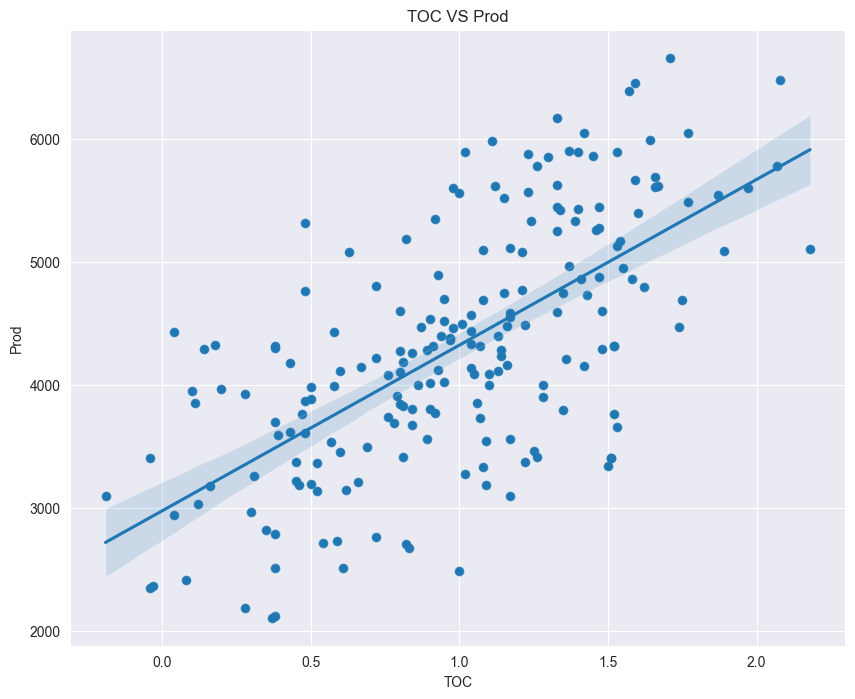

In [98]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.scatterplot(x='TOC', y='Prod', data=data).set_title('TOC VS Prod');
sns.regplot(data=data, x='TOC', y='Prod', ax=axes)

График зависимости признака TOC от целевой переменной Prod показывает прямую и линейную зависимость между признаками.


### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [99]:
new_X = X.drop(['Well', 'Perm', 'TOC'], axis = 1)
A = np.column_stack((np.ones(200), new_X))

w_hat=np.linalg.inv(A.T@A)@A.T@y
print('w_hat: {}'.format(np.round(w_hat.values, 0)))

y_pred = (A@w_hat)
mape = abs((y-y_pred))/y
print('MAPE: {}'.format(np.round(mape.sum()/200*100, 1)))

w_hat: [[-1835.]
 [  293.]
 [ -200.]
 [   28.]
 [  517.]]
MAPE: Prod    4.0
dtype: float64


In [102]:
print('Rank:', np.linalg.matrix_rank(new_X .corr()))
print('Determinant:', round(np.linalg.det(new_X .corr()), 4))

Rank: 4
Determinant: 0.3683


После удаления признаков мы получили:

Матрицу максимального ранга
Определитель матрицы составил 0.3683, что говорит о том, что мы ушли от вырожденности
Зависимости сохранились (знаки в матрице корреляций и знаки коэффициентов совпадают)


### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [107]:
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(A, y)
print('w_hat:', np.round(model.coef_, 0))
new_prediction = model.predict(A)

print('MAPE score:', round(metrics.mean_absolute_percentage_error(y, new_prediction) * 100, 2))

w_hat: [[-1835.   293.  -200.    28.   517.]]
MAPE score: 4.04


In [104]:
# до введения полинома
cv_results = model_selection.cross_validate(model, A, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 4.02 %
MAPE на валидационных фолдах: 4.23 %


Коэффициенты при расчете модели линейной регрессии методами sklearn полностью совпали с коэффициентами, расчитанными вручную

Выбранная метрика так же полностью совпала

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [108]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [118]:
scaler = StandardScaler()
X = scaler.fit_transform(new_X)
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)
print('После генерации полиноминальных признаков получилось:', X.shape[1], 'факторов')

lr = LinearRegression()

# оцениваем качество модели на кросс-валидации, метрика — MAPE
cv_results = cross_validate(lr, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print(f'MAPE на тренировочных фолдах: { round(-cv_results["train_score"].mean() * 100, 2) }')
print(f'MAPE на валидационных фолдах: { round(-cv_results["test_score"].mean() * 100, 2) }')

После генерации полиноминальных признаков получилось: 34 факторов
MAPE на тренировочных фолдах: 1.77
MAPE на валидационных фолдах: 2.68


После генерации полиноминальных признаков получилось 34 факторов

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [110]:
param = {
    'alpha': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
}

lasso = Lasso()

grid_search = GridSearchCV(
    estimator=lasso,
    param_grid=param,
    cv=5,
    n_jobs = -1,

)

grid_search.fit(X, y)

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

lasso = Lasso(alpha = 6)

cv_results = cross_validate(lasso, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print(f'MAPE на тренировочных фолдах: { round(-cv_results["train_score"].mean() * 100, 2) }')
print(f'MAPE на валидационных фолдах: { round(-cv_results["test_score"].mean() * 100, 2) }')

Наилучшие значения гиперпараметров: {'alpha': 6}
MAPE на тренировочных фолдах: 1.85
MAPE на валидационных фолдах: 2.28


По результатам отбора лучший коэффициент регуляризации - 6
Удалось улучшить метрики как на тренировочных так и на тестовых фолдах

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [111]:
param = {
    'alpha': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
}

ridge = Ridge()

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param,
    cv=5,
    n_jobs = -1
)

grid_search.fit(X, y)

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

ridge = Ridge(alpha=1)

print(f'MAPE на тренировочных фолдах: { round(-cv_results["train_score"].mean() * 100, 2) }')
print(f'MAPE на валидационных фолдах: { round(-cv_results["test_score"].mean() * 100, 2) }')

Наилучшие значения гиперпараметров: {'alpha': 1}
MAPE на тренировочных фолдах: 1.85
MAPE на валидационных фолдах: 2.28


По результатам подбора лучший коэффициент регуляризации 1

Метрики так же улучшились относительно регрессии на полиноме 3й степени без регуляризации, однако L-1 регуляризация показала лучший результат

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [112]:
param = {
    'alpha': [0, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'l1_ratio' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

elasticnet = ElasticNet()

grid_search = GridSearchCV(
    estimator=elasticnet,
    param_grid=param,
    cv=5,
    n_jobs = -1
)

grid_search.fit(X, y)

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.9)

cv_results = cross_validate(elasticnet, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print(f'MAPE на тренировочных фолдах: { round(-cv_results["train_score"].mean() * 100, 2) }')
print(f'MAPE на валидационных фолдах: { round(-cv_results["test_score"].mean() * 100, 2) }')

Наилучшие значения гиперпараметров: {'alpha': 0.1, 'l1_ratio': 0.9}
MAPE на тренировочных фолдах: 1.88
MAPE на валидационных фолдах: 2.76


Лучшие коэффициенты по результатам подбора гиперпараметров 'alpha': 0.1, 'l1_ratio': 0.9

Метрики так же улучшились относительно регрессии на полиноме 3й степени без регуляризации, однако L-1 регуляризация показала лучший результат


### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [119]:
df = pd.DataFrame(
    {
        'Модель' : [
            'LinearRegression',
            'LinearRegression',
            'Lasso',
            'Ridge',
            'ElasticNet'
        ],
        'Гиперпараметры': [
            '-',
            '-',
            'alpha = 6',
            'alpha=1',
            'alpha=0.1, l1_ratio=0.9'
        ],
        'Полиноминальные признаки': [
            'Нет',
            'Да',
            'Да',
            'Да',
            'Да'
        ],
        'MAPE_train': [
            '4.02 %',
            '1.77 %',
            '1.85 %',
            '1.83 %',
            '1.88 %'
        ],
        'MAPE_test': [
            '4.23 %',
            '2.68 %',
            '2.28 %',
            '2.72 %',
            '2.76 %'
        ]
    }
)
df

,Модель,Гиперпараметры,Полиноминальные признаки,MAPE_train,MAPE_test
0,LinearRegression,-,Нет,4.02 %,4.23 %
1,LinearRegression,-,Да,1.77 %,2.68 %
2,Lasso,alpha = 6,Да,1.85 %,2.28 %
3,Ridge,alpha=1,Да,1.83 %,2.72 %
4,ElasticNet,"alpha=0.1, l1_ratio=0.9",Да,1.88 %,2.76 %


Введение регуляризации оказало ощутимый эффект на улучшение качества модели. Лучшие результаты показала линейная регрессия с L-1 регуляризацией.